In [1]:
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Flatten, GlobalAveragePooling2D, Reshape, Dense, multiply, Lambda
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [2]:
train_dir = r'D:\Download\zyFile\Machine_Vision\MV_Seminar_Week 2\Machine_Vision_homework\MV_Seminar Week 5\data_mv\train'
test_dir = r'D:\Download\zyFile\Machine_Vision\MV_Seminar_Week 2\Machine_Vision_homework\MV_Seminar Week 5\data_mv\test'

In [3]:
# Load and preprocess the training data
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',  # Assuming labels are provided as integers
    color_mode='rgb'  # Assuming images are grayscale
)

Found 48 images belonging to 3 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 24 images belonging to 3 classes.


In [5]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [6]:
# Load pre-trained VGG16 model (excluding top layers)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [7]:
# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)

# Add attention mechanism 

### This line creates a dense layer with a single unit and a tanh activation function. 

- This layer is responsible for computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer. 
- The tanh activation is chosen here to squash the output to the range [-1, 1], helping the network to learn attention weights.

In [8]:
#computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer
attention = Dense(1, activation='tanh')(x)

### The attention weights are reshaped to have dimensions (-1, 1, 1). This reshaping is done to match the shape of the original input tensor x, facilitating the subsequent element-wise multiplication.  This prepares the attention weights to be applied element-wise to the original feature representation.


- In the line of code `attention = Reshape((-1, 1, 1))(attention)`, the tuple `(-1, 1, 1)` specifies the desired shape to which the `attention` tensor is being reshaped. Let's break down each dimension:

- The first dimension, represented by `-1`, is a placeholder for an unknown size. The value of `-1` is inferred based on the size of the original tensor, such that the total number of elements remains constant. This is often used when you want to maintain the original size along that axis.

- The second and third dimensions are explicitly set to `1`. This means that the reshaped tensor will have a size of 1 along these dimensions.

The purpose of reshaping with `(-1, 1, 1)` is often to flatten the tensor along certain axes while preserving the total number of elements. Specifically, in this case:

- The original tensor has some shape `(batch_size, height, width, channels)`.
- After applying the attention mechanism, the tensor has been modified, and reshaping is applied to it.
- The reshaping transforms the tensor into a shape of `(batch_size, 1, 1, 1)`.

This reshaping might be necessary for compatibility with subsequent operations or layers in the neural network architecture. In the context of attention mechanisms, it is common to reshape attention weights to ensure that they can be easily applied to the original feature representation using element-wise multiplication.

In summary, `(-1, 1, 1)` is used to reshape the tensor in such a way that it flattens along certain axes while maintaining the original size along other axes, and the specific size along the flattened axes is set to `1`.

In [9]:
# Reshape attention to have dimensions (-1, 1, 1)
attention = Reshape((-1, 1, 1))(attention)

### The attention weights are applied element-wise to the original feature representation (x) using the multiply function. This step emphasizes or de-emphasizes certain elements based on their relevance determined by the attention weights.

In [10]:
# Apply the attention weights element-wise to the original feature representation (x) 
attention = multiply([x, attention])

### The attention weights are summed along the channel axis (-2). 

- This aggregation step produces a single attention value for each spatial location in the input tensor.

- In the line of code `attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)`, several concepts are at play:

1. **Lambda:**
   - `Lambda` is a wrapper in Keras that allows you to use a custom function (specified using a lambda function) as a layer in your neural network.
   - It is used to define a simple, one-line anonymous function.

2. **lambda x:**
   - This part is a lambda function, a concise way to define a small, inline function without explicitly naming it.
   - In this case, the lambda function takes a single argument `x` and applies the operation defined in the function.

3. **K.sum(x, axis=-2):**
   - `K.sum` is a function from the Keras backend (`K`) that computes the sum of elements along a specified axis.
   - In this case, it sums the elements along the axis specified by `-2`. The axis is counted from the last dimension, so `-2` corresponds to the channel axis in a typical 4D tensor representing images (batch_size, height, width, channels).

4. **axis=-2:**
   - This specifies the axis along which the summation operation should be performed.
   - The value `-2` corresponds to the channel axis in a 4D tensor. It ensures that the attention values are summed along the channel dimension, producing a single attention value for each spatial location.

Putting it all together, the line of code is essentially saying: "Use a Lambda layer to apply a summation operation along the channel axis (-2) for the input tensor `x`."

Example illustration:

Suppose `attention` is a tensor with shape `(batch_size, height, width, channels)`. The lambda function is applied to this tensor, and the `K.sum(x, axis=-2)` operation sums the values along the channel axis, resulting in a tensor with shape `(batch_size, height, width, 1)`. Each element in the resulting tensor represents the aggregated attention value for a specific spatial location in the input tensor. This aggregated attention value captures the importance of different channels at each spatial location.

In [11]:
# The attention weights are summed along the channel axis (-2) to produces a single attention value 
attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)

### The attention values are expanded along a new axis (-1). This step is necessary to match the expected input shape of the GlobalAveragePooling2D layer.

In the line of code `attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)`, the operations involve the Keras backend functions `Lambda`, `K.expand_dims`, and the `axis` parameter. Let's break it down:

1. **Lambda:**
   - `Lambda` is a wrapper in Keras that allows you to use a custom function (specified using a lambda function) as a layer in your neural network.

2. **lambda x:**
   - This part is a lambda function, a concise way to define a small, inline function without explicitly naming it.
   - In this case, the lambda function takes a single argument `x` and applies the operation defined in the function.

3. **K.expand_dims(x, axis=-1):**
   - `K.expand_dims` is a function from the Keras backend (`K`) that adds a new axis to a tensor at a specified position.
   - In this case, it adds a new axis at the end of the tensor (`axis=-1`), effectively expanding the tensor shape.

4. **axis=-1:**
   - This specifies the axis at which the new dimension should be added. The value `-1` corresponds to the last axis of the tensor.

Putting it all together, the line of code is essentially saying: "Use a Lambda layer to apply the `K.expand_dims` operation to the input tensor `x`, adding a new dimension at the end of the tensor."

Example illustration:

Suppose `attention` is a tensor with shape `(batch_size, height, width)`. The lambda function is applied to this tensor, and the `K.expand_dims(x, axis=-1)` operation adds a new dimension at the end of the tensor, resulting in a tensor with shape `(batch_size, height, width, 1)`. The new dimension at the end represents the expanded axis. This expansion is often done to prepare the tensor for subsequent operations or layers that expect a certain number of dimensions.

In [12]:
# The attention values are expanded along a new axis (-1)
attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

###  The resulting tensor from the attention mechanism is globally averaged along the spatial dimensions. This is a simple way to aggregate the attended features into a fixed-size representation.


In [13]:
# computes the average of all the values along each channel
attention = GlobalAveragePooling2D()(attention)

### Finally, the output layer is a dense layer with 3 units (assuming it's a classification task with three classes) and a softmax activation function. This layer produces the final probability distribution over the three classes.

In [14]:
merged = Dense(3, activation='softmax')(attention)

In [15]:
# Create the new model
model = Model(inputs=base_model.input, outputs=merged)

In [16]:
# Freeze base layers to prevent their weights from being updated
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Train the model
history=model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 1.0985 - accuracy: 0.4167 - val_loss: 1.1971 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 1.0212 - accuracy: 0.4167 - val_loss: 1.3109 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.9613 - accuracy: 0.4167 - val_loss: 1.3820 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 0.9087 - accuracy: 0.4167 - val_loss: 1.4166 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 0s 32ms/step - loss: 0.8643 - accuracy: 0.4167 - val_loss: 1.4560 - val_accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 0s 47ms/step - loss: 0.8325 - accuracy: 0.4167 - val_loss: 1.5055 - val_accuracy: 0.2500
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: 0.8055 - accuracy: 0.4167 - val_loss: 1.5654 - val_accuracy: 0.2500
Epoch 8/10
1/1 [===========

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 1s 690ms/step - loss: 1.2133 - accuracy: 0.3750
Test accuracy: 0.375
Test loss: 1.2133243083953857


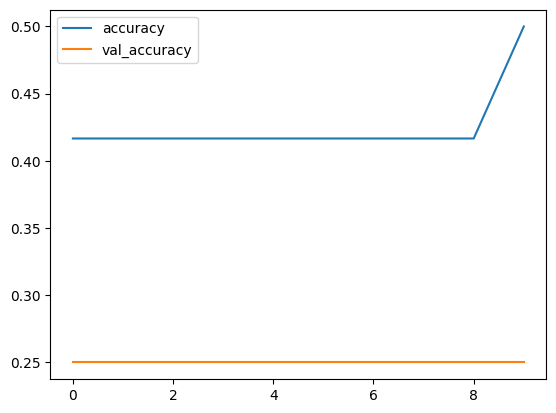

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

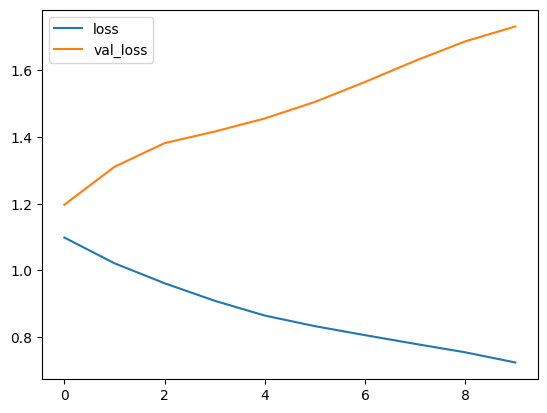

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [23]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [24]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()